<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Instance Segmentation and Analysis of Plant Phenotypes

In this notebook, we will view and run a production-grade **Instill VDP** pipeline hosted on **Instill Cloud** to perform instance segmentation of microscopic images of plant stomata.

### Setup

To execute all of the code in this notebook, you’ll need to create a free **Instill Cloud** account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [1]:
!pip install instill-sdk==0.13.0 --quiet

In [2]:
import base64
import requests
from google.protobuf.json_format import MessageToDict
from IPython.display import display, HTML, IFrame
import pandas as pd
import numpy as np
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


from instill.clients import init_pipeline_client
pipeline = init_pipeline_client(api_token="YOUR_INSTILL_API_TOKEN")

### Background

[Stomata](https://en.wikipedia.org/wiki/Stoma) are tiny pores on plant leaves that regulate water loss and CO2 uptake. Assessing stomata helps us understand plant responses to environmental challenges, crucial for developing stress-resistant crops and sustainable farming. This knowledge also impacts climate regulation and water resource management.

### Load an example image

Let's now load and view an example image of plant stomata under the microscope 🔬.


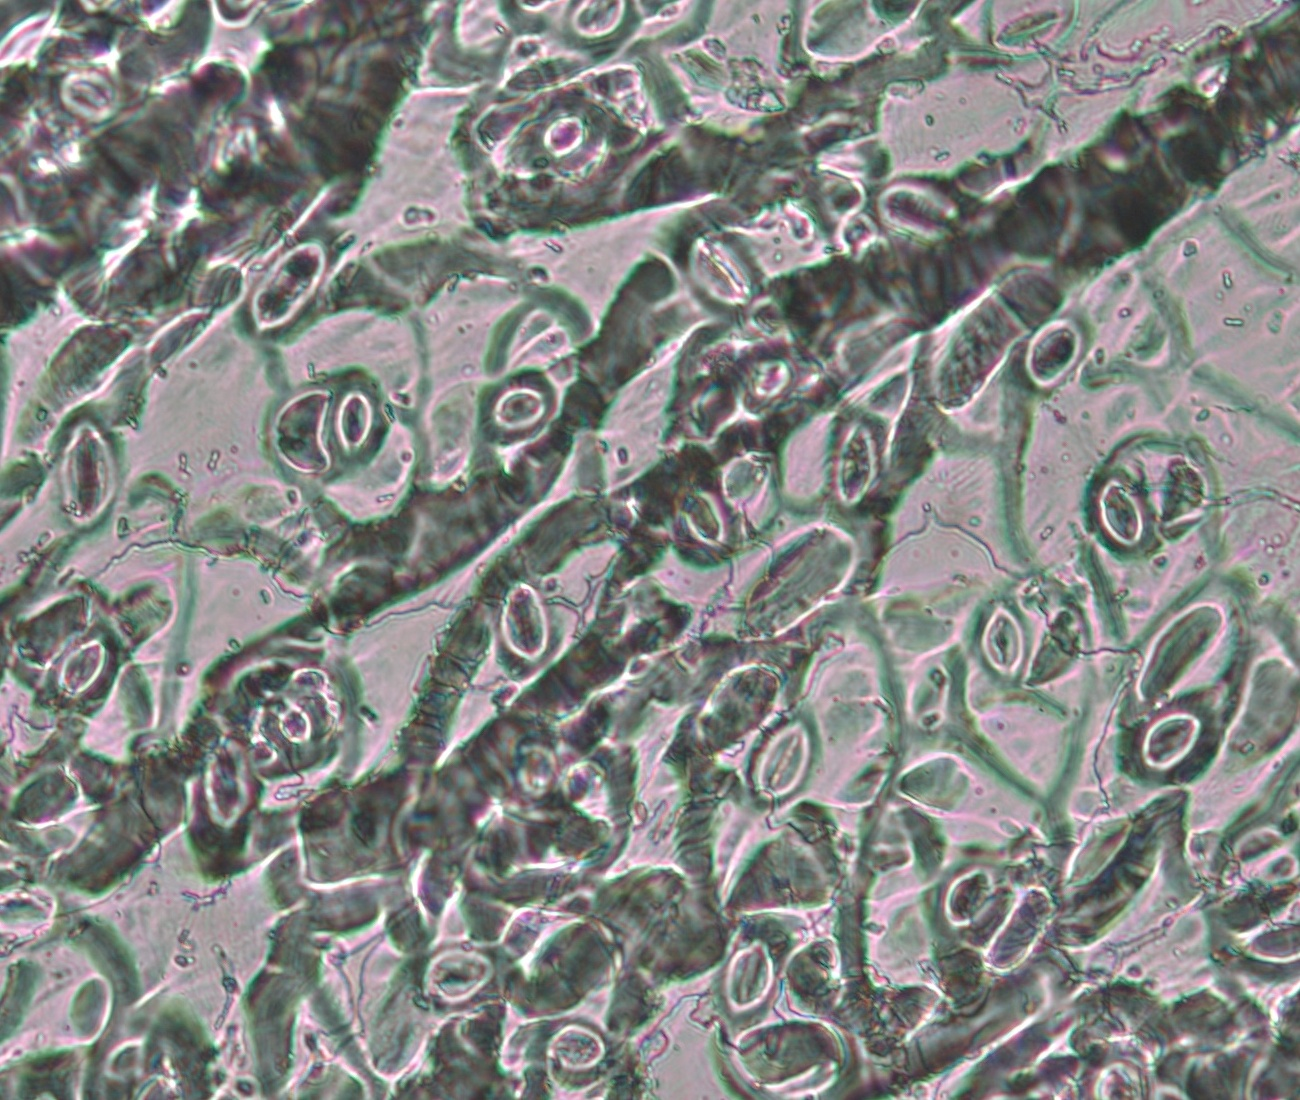

In [4]:
response = requests.get('https://raw.githubusercontent.com/instill-ai/cookbook/main/data/stomata_sample.jpg')

base64_image = base64.b64encode(response.content).decode('utf-8')

img_tag = f'<img src="data:image/jpeg;base64,{base64_image}" width="600"/>'
display(HTML(img_tag))

### Challenge: Overcoming Traditional Analysis Bottlenecks

Traditional stomata analysis methods, like microscopy and manual counting, are labor-intensive, time-consuming, error-prone, and hard to scale. Automated solutions often fail to adapt to different plant species and imaging conditions, and struggle to accurately measure key stomatal traits such as aspect ratio, pore size, and dynamic states. This limits our understanding of plant physiology and broader application in plant research.

### Solution: **☁️ Instill Cloud**

This challenge is addressed by the **[Instill VDP](https://www.instill.tech/docs/vdp/introduction)** pipeline, which powers StomaVision—a cutting-edge tool for efficient, scalable stomata detection and measurement across diverse plant species and imaging conditions. This pipeline connects to a fine-tuned `YOLOv7-seg` model, deployed via **[Instill Model](https://www.instill.tech/docs/model/introduction)** all on **[Instill Cloud](https://www.instill.tech/docs/cloud/introduction)**.

Please view and explore the README for the public StomaVision **Instill VDP** pipeline for further information.

In [5]:
IFrame('https://instill.tech/abrc/pipelines/stomavision/readme?version=v1.0.0', width=1000, height=800)

### Run this pipeline on **☁️ Instill Cloud** from this notebook

Here we will use the Instill Python SDK to run the example image through the StomaVision pipeline.

In [6]:
response = pipeline.trigger_release(
    namespace_id="abrc",
    pipeline_id="stomavision",
    release_id="v1.0.0",
    data=[{"input": base64_image}],
)
pipeline.close()

### View the results

Let's have a look at the output annotated image which is encoded as a base64 string in the response object. This will show our predicted stomata segmentation masks.


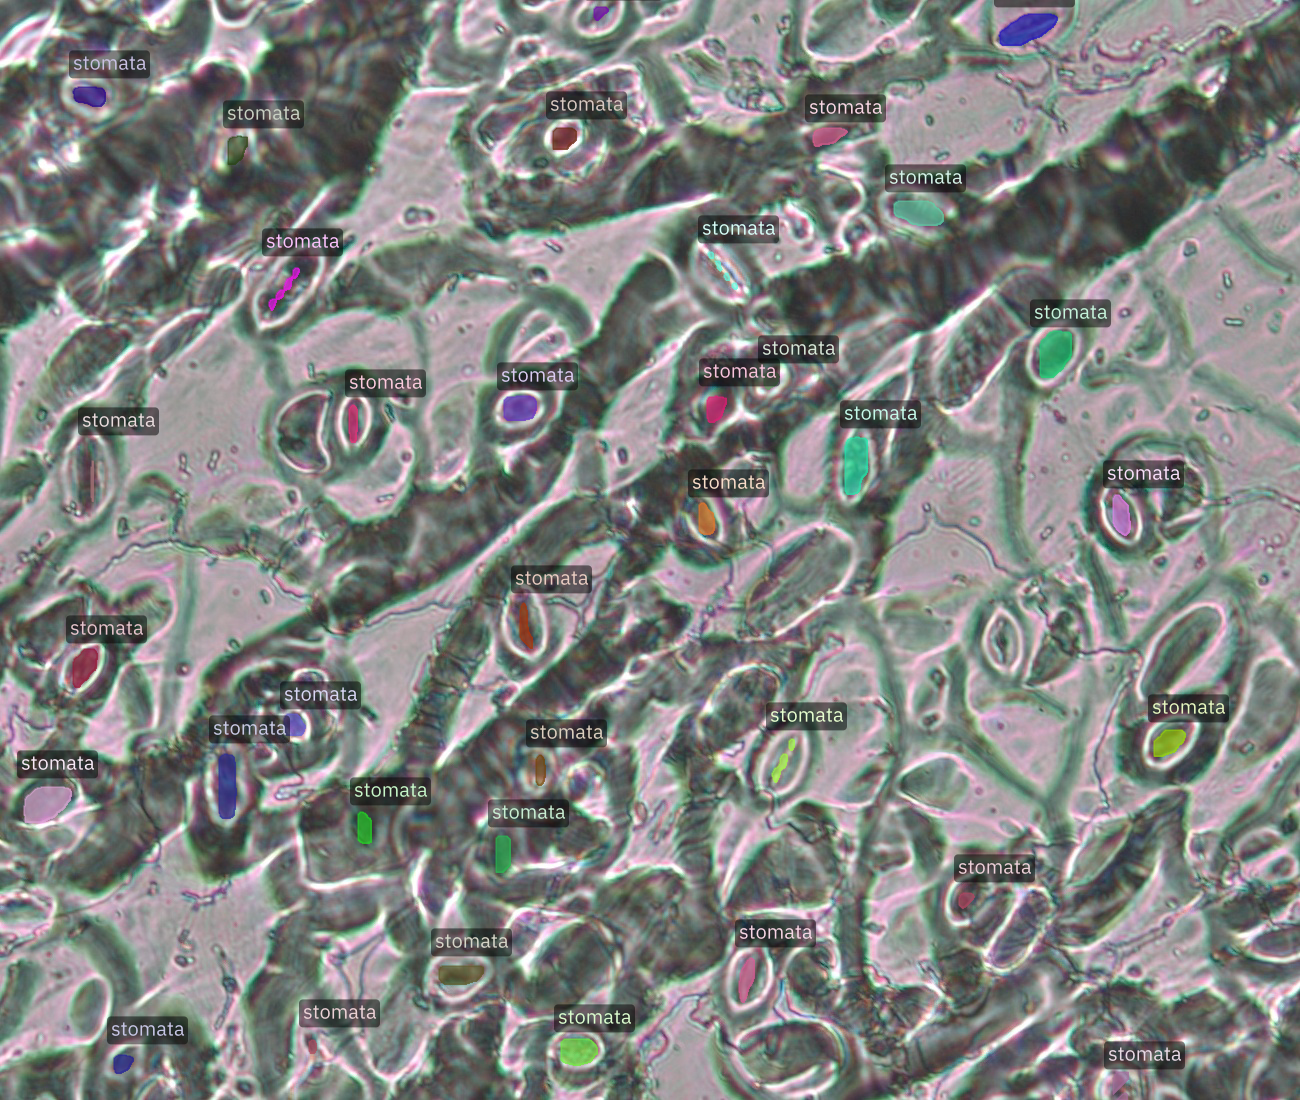

In [7]:
data = MessageToDict(response)

output_base64_image = data['outputs'][0]['vis'].split(',')[1]

img_tag = f'<img src="data:image/jpeg;base64,{output_base64_image}" width="600"/>'
display(HTML(img_tag))

The response also contains a plethora of additional information that can be used for extracting further insights.

{'outputs': [{'vis': '',
   'objects': [{'rle': '302,32,13,37,10,38,9,39,9,39,8,40,7,41,5,43,4,44,3,45,2,46,2,46,2,46,1,47,1,46,2,45,3,44,4,43,5,42,6,41,7,41,7,40,9,38,10,37,11,35,13,33,15,31,17,30,18,29,19,28,21,26,23,22,70',
     'score': 0.89404296875,
     'bounding-box': {'height': 48.0,
      'left': 1034.0,
      'top': 330.0,
      'width': 39.0},
     'category': 'stomata'},
    {'rle': '94,18,10,20,8,22,6,24,5,24,5,24,5,24,5,24,5,24,5,24,5,24,5,24,4,25,4,25,4,25,4,25,4,25,4,25,4,25,4,25,4,25,4,25,4,24,5,24,5,24,5,24,5,23,7,22,7,22,7,21,9,18,12,15,16,10,98',
     'score': 0.8935546875,
     'bounding-box': {'left': 501.0,
      'height': 29.0,
      'top': 393.0,
      'width': 39.0},
     'category': 'stomata'},
    {'rle': '10,3,21,10,15,13,13,14,12,14,11,16,10,16,10,16,10,16,10,16,10,16,10,17,9,17,9,17,9,17,9,18,8,18,8,19,7,19,7,20,6,20,6,20,6,20,6,20,7,19,7,19,7,19,7,19,7,19,7,18,9,16,11,14,14,10,31',
     'score': 0.8857421875,
     'bounding-box': {'left': 73.0,
      'h
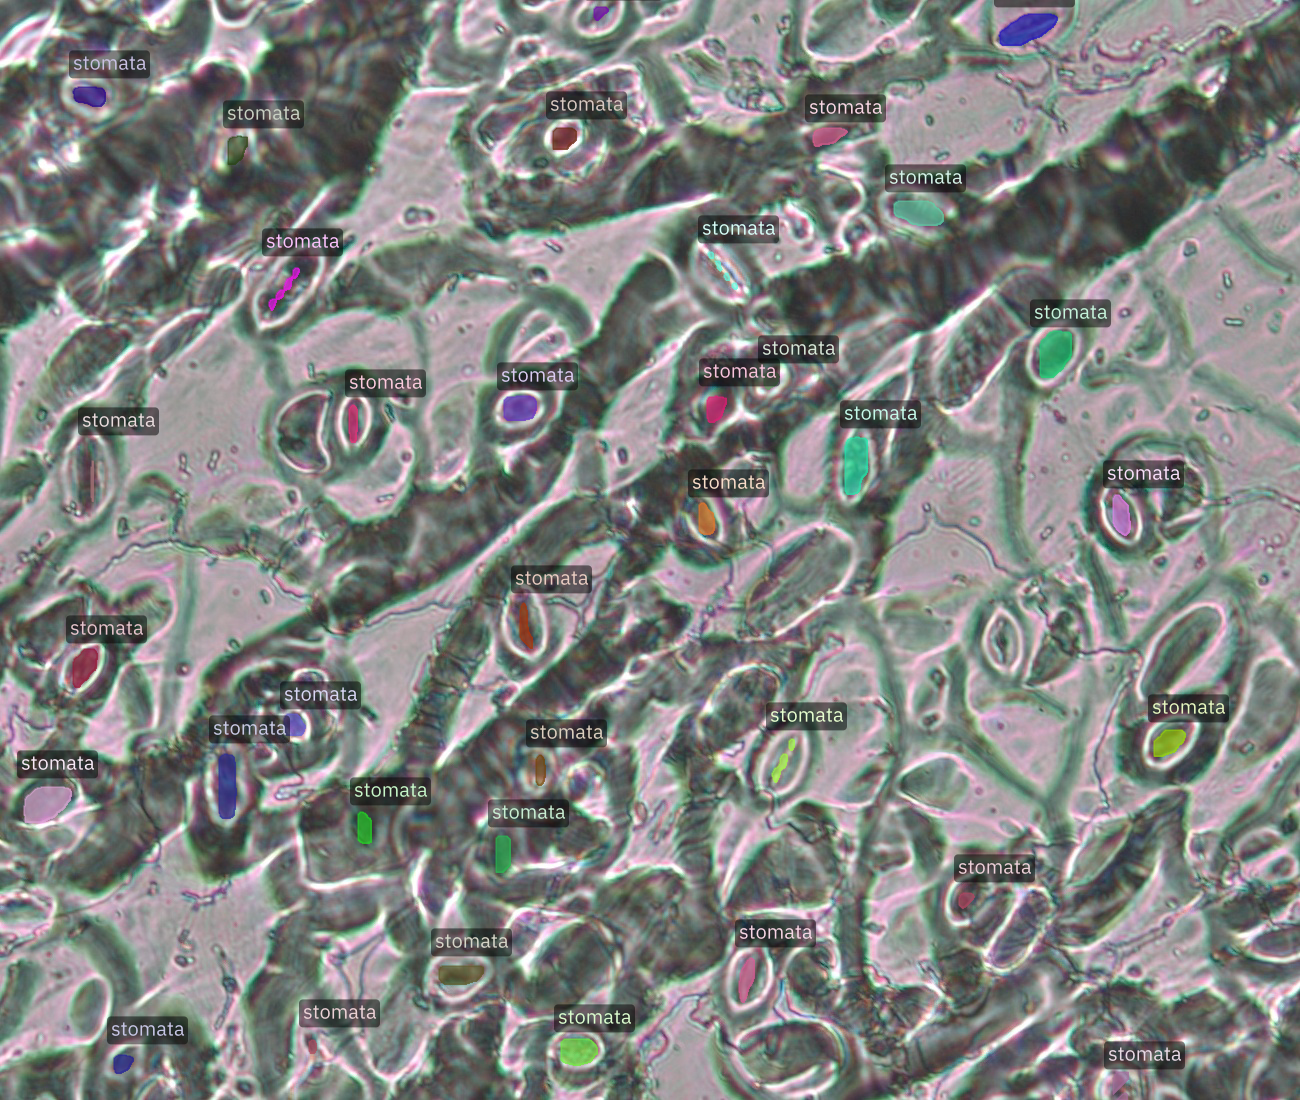

In [8]:
data

### Insights

Here are some example insights and statistics that you can calculate based on data contained in the output response object.

**How many stomata are present?**

In [9]:
objects = data['outputs'][0]['objects']

total_stomata = len(objects) - 1
print(f"Total number of stomata detected: {total_stomata}")

Total number of stomata detected: 34


**What are the average bounding box dimensions?**

In [10]:
heights = [obj['bounding-box']['height'] for obj in objects]
widths = [obj['bounding-box']['width'] for obj in objects]
areas = [height * width for height, width in zip(heights, widths)]

average_height = np.mean(heights)
average_width = np.mean(widths)
average_area = np.mean(areas)

print(f"Average bounding box height (in pixels): {average_height:.2f}")
print(f"Average bounding box width (in pixels): {average_width:.2f}")
print(f"Average bounding box area (in squared pixels): {average_area:.2f}")

Average bounding box height (in pixels): 38.97
Average bounding box width (in pixels): 28.91
Average bounding box area (in squared pixels): 1097.26


**How much variability in stomata size is there?**

In [11]:
std_dev_height = np.std(heights)
std_dev_width = np.std(widths)
std_dev_area = np.std(areas)

print(f"Standard deviation of bounding box height (in pixels): {std_dev_height:.2f}")
print(f"Standard deviation of bounding box width (in pixels): {std_dev_width:.2f}")
print(f"Standard deviation of bounding box area (in squared pixels): {std_dev_area:.2f}")

Standard deviation of bounding box height (in pixels): 14.20
Standard deviation of bounding box width (in pixels): 12.40
Standard deviation of bounding box area (in squared pixels): 554.28


**What is the average detection score?**

In instance segmentation, the detection score is a measure of the confidence or probability that a given object or instance in an image has been correctly identified and segmented.

In [12]:
scores = [obj['score'] for obj in objects]
average_score = np.mean(scores)

print(f"Average detection score: {average_score:.4f}")

Average detection score: 0.8334


**Can we view the relationship between detection score and segmentation size?**

Unsurprisingly, we see that the detection score increases with stomata size.

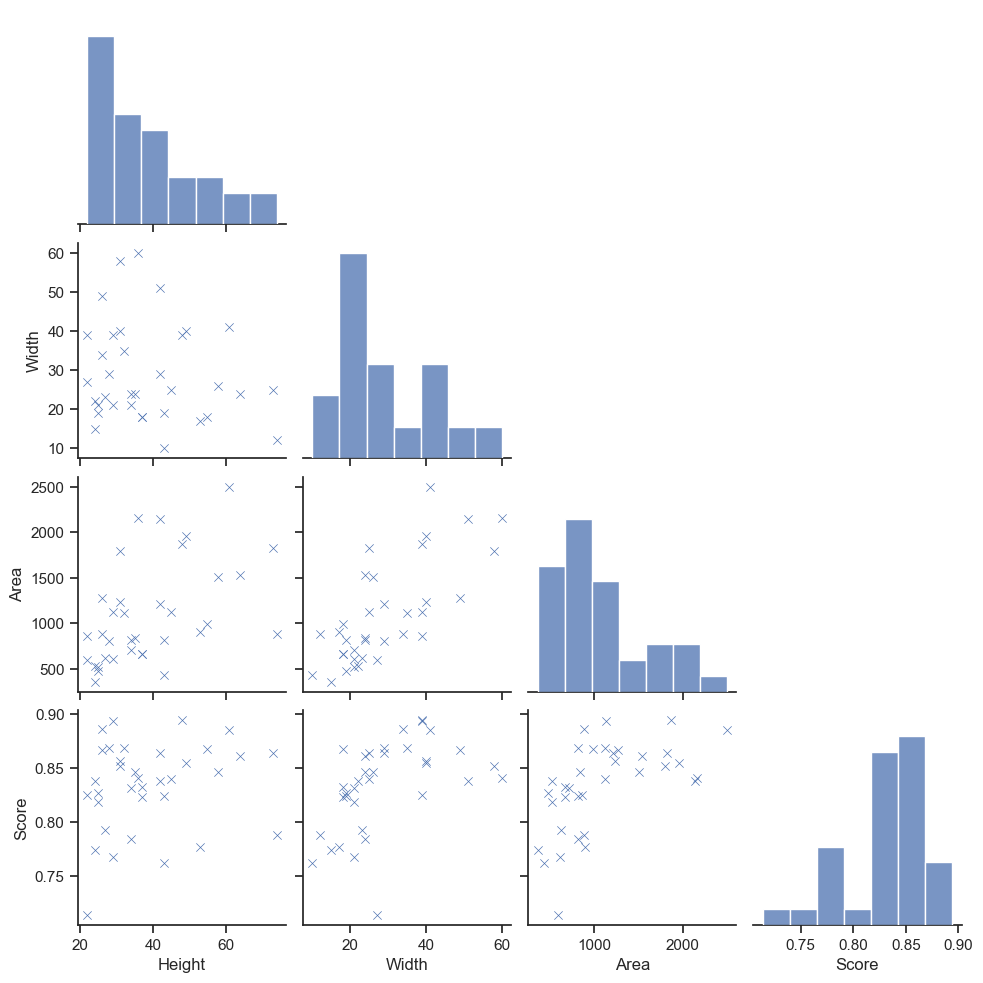

In [13]:
df = pd.DataFrame({
    'Height': heights,
    'Width': widths,
    'Area': areas,
    'Score': scores,
})

sns.pairplot(df, corner=True, markers='x')

#### References

[[1]](https://www.biorxiv.org/content/10.1101/2024.04.24.590919v1) Wu, Ting-Li, Po-Yu Chen, Xiaofei Du, Heiru Wu, Jheng-Yang Ou, Po-Xing Zheng, Yu-Lin Wu et al. "StomaVision: stomatal trait analysis through deep learning." _bioRxiv_ (2024): 2024-04.

[[2]](https://github.com/YaoChengLab/StomaVision) StomaVision project page and repository.

[[3]](https://instill.tech/abrc/pipelines/stomavision/readme?version=v1.0.0) **💧 Instill VDP** pipeline.

[[4]](https://instill.tech/abrc/models/yolov7-stomata/playground) Fine-tuned YOLOv7 instance segmentation model hosted with **⚗️ Instill Model** on **☁️ Instill Cloud**.